In [1]:
import numpy as np

discreteness = 20
learning_rate = 0.2
iterations = 10000
action_randomness = 0.5
action_randomness_decay_rate = (1 - action_randomness) / iterations
discount_factor = 0.99
render_period = 1000
env_name = 'MountainCar-v0'

In [2]:
def make_discrete(env, observation):
    discrete = []
    for low, high, value in zip(env.observation_space.low, env.observation_space.high, observation):
        discrete.append(int((value - low) / (high - low) * discreteness))
    return discrete

In [3]:
import random

q_table = None
def create_q_table(env):
    global q_table
    # env.action_space.shape
    # np.append(env.observation_space.shape, env.action_space.n)
    q_table_shape = [discreteness for i in range(env.observation_space.shape[0])]
    q_table_shape.append(env.action_space.n)
    q_table = np.random.sample(q_table_shape)

def get_action(env, state):
    global action_randomness
    
    action_randomness -= action_randomness_decay_rate
    action = 0
    if random.random() > action_randomness:
        state_discrete = make_discrete(env, state)
        action = q_table[tuple(state_discrete)].argmax()
    else:
        action = random.randint(0, env.action_space.n - 1)
    return action
    
def get_action2(env, state):
    position = state[0]
    velocity = state[1]
    
    if min(-0.09*(position + 0.25)**2 + 0.03, 0.3*(position + 0.9)**4 - 0.008 <= velocity <= -0.07*(position + 0.38)**2 + 0.07):
        action = 2
    else:
        action = 0
    return action
    
def update_q_table(env, state_old, action, state_new, reward):
    state_old_discrete = make_discrete(env, state_old)
    state_new_discrete = make_discrete(env, state_new)
    #print(state_old_discrete)
    q_table[tuple(state_old_discrete + [action])] = (1 - learning_rate) * q_table[tuple(state_old_discrete + [action])] \
                                + learning_rate * (reward + discount_factor * q_table[tuple(state_new_discrete)].max())

In [ ]:
import gym
env = gym.make(env_name)
print(env.observation_space.low)
print(env.observation_space.high)

[-1.2  -0.07]
[0.6  0.07]


In [ ]:
import gym
from tqdm import tqdm_notebook

env = gym.make(env_name)
create_q_table(env)
observation = env.reset()

record = env.spec.max_episode_steps - 1
history = []

for i in tqdm_notebook(range(iterations)):
    observation = env.reset()
    done = False
    reward_sum = 0
    for j in range(env.spec.max_episode_steps):
        if i % render_period == 0:
            env.render(mode='rgb_array')
        
        observation_old = observation
        action = get_action(env, observation)
        observation, reward, done, info = env.step(action)
        reward_sum += reward

        update_q_table(env, observation_old, action, observation, reward)
        
        if done == True:
            history.append(reward_sum)
            if j < record:
                print(f'New high score: {j} steps on {i} iteration')
                record = j
            break
            
env.close()

New high score: 174 steps on 248 iteration
New high score: 173 steps on 249 iteration
New high score: 169 steps on 250 iteration
New high score: 167 steps on 276 iteration
New high score: 166 steps on 404 iteration
New high score: 162 steps on 464 iteration
New high score: 158 steps on 468 iteration
New high score: 157 steps on 571 iteration
New high score: 153 steps on 572 iteration
New high score: 151 steps on 578 iteration
New high score: 147 steps on 580 iteration
New high score: 122 steps on 1162 iteration
New high score: 121 steps on 3289 iteration
New high score: 92 steps on 3542 iteration



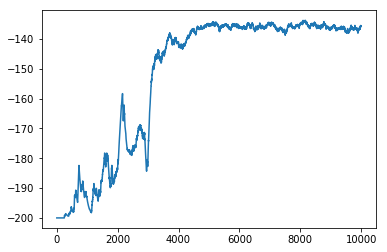

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.99):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(np.arange(len(history)), smoothen_curve(history))

In [ ]:
import time

env = gym.make(env_name)
observation = env.reset()

for i in range(iterations):
    observation = env.reset()
    done = False
    for j in range(env.spec.max_episode_steps):
        env.render()
        time.sleep(0.1)
        
        action = get_action(env, observation)
        observation, reward, done, info = env.step(action)
        
        if done == True:
            if j < env.spec.max_episode_steps - 1:
                print(f'Win {j} steps on {i} iteration')
            break
env.close()

Win 123 steps on 0 iteration
Win 123 steps on 1 iteration
Win 138 steps on 2 iteration
Win 123 steps on 3 iteration
Win 124 steps on 4 iteration
Win 139 steps on 5 iteration
Win 151 steps on 6 iteration
Win 139 steps on 7 iteration
Win 152 steps on 8 iteration
Win 148 steps on 9 iteration
Win 143 steps on 10 iteration
Win 125 steps on 11 iteration
Win 124 steps on 12 iteration
Win 151 steps on 13 iteration
Win 124 steps on 14 iteration
Win 139 steps on 15 iteration
Win 124 steps on 16 iteration
Win 138 steps on 17 iteration
Win 151 steps on 18 iteration
Win 138 steps on 19 iteration
Win 123 steps on 20 iteration
Win 138 steps on 21 iteration
Win 153 steps on 22 iteration
Win 139 steps on 23 iteration
Win 139 steps on 24 iteration
Win 125 steps on 25 iteration
Win 124 steps on 26 iteration
Win 151 steps on 27 iteration
Win 127 steps on 28 iteration
Win 138 steps on 29 iteration
Win 150 steps on 30 iteration
Win 122 steps on 31 iteration
Win 147 steps on 32 iteration
Win 125 steps on 33 